# Chapter 6 Practice Answers

In [1]:
from causalgraphicalmodels import CausalGraphicalModel
import numpy as np
import pymc as pm
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
from watermark import watermark

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%load_ext watermark
%watermark

Last updated: 2024-07-02T11:26:15.191729-04:00

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.17.2

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 141 Stepping 1, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [3]:
%watermark --iversions

pymc      : 5.9.2
numpy     : 1.25.2
matplotlib: 3.8.2
pandas    : 2.1.3
arviz     : 0.16.1



# 6E1 Question
List three mechanisms by which multiple regression can produce false inferences about causal effects.

6E1 Answer:  Multicollinearality, post treatment bias, and collider bias

# 6E2 Question
For one of the mechanisms in the previous problem, provide an example of your choice, perhaps from your own research.


6E2 Answer: Multicollinearlity Example: We want to predict how much somebody is going to pee based on room temperature and sweating.  However, temperature and sweating may be measuring the same thing.

Collider Bias: Let's say you want to predict how good somebody will be at golf as an adult, based on ranking them on how good they are at a childhood sport, GPA, diet, and parental income.  Parental income is likely to be a collider since it can determine free time (for sports or studying) and nutrition 

# 6E3 Question 
List the four elemental confounds. Can you explain the conditional dependencies of each?

6E3 Answer: 

The Fork: X<- Z -> Y: X is independent of Y, conditional on Z

The Pipe: X -> Z -> Y: Conditioning from Z blocks the path from X to Y

The Collider: X -> Z <- Y: X and Y have no relation unless conditioned on Z

The Descendent: X -> Z <- Y, Z->D: X and Y have no relation uness conditioned on Z.  Conditioning on D will open a partial path

# 6E4 Question: 
How is a biased sample like conditioning on a collider? Think of the example at the open of the chapter.

6E4 Answer: When you add the collider, you create a relationship that wasn't there before X and Y.  So you bias the analysis and create a relationship that isn't there.  If the collider is latent and unobserved, you may assume there is a direct relationship between X and Y that isn't really there.

# 6M1 Question: 
Modify the DAG on page 186 to include the variable V, an unobserved cause of C and Y: C ← V → Y. Reanalyze the DAG. How many paths connect X to Y? Which must be closed? Which variables should you condition on now?

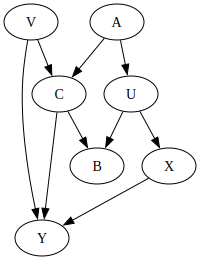

In [7]:
sixM1 = CausalGraphicalModel(
    nodes = ['A','U','B','C','X','Y','V'],
    edges = [
    ('A','U'),
    ('A','C'),
    ('U','B'),
    ('U','X'),
    ('C','B'),
    ('C','Y'),
    ('X','Y'),
    ('V','C'),
    ('V','Y')]
)
sixM1.draw()


In [8]:
sixM1.get_all_backdoor_paths('X','Y')

[['X', 'U', 'A', 'C', 'Y'],
 ['X', 'U', 'A', 'C', 'V', 'Y'],
 ['X', 'U', 'B', 'C', 'Y'],
 ['X', 'U', 'B', 'C', 'V', 'Y']]

#There are now 5 paths from X to Y

1. X <- U <- A -> C -> Y

2. X <- U <- A -> C <- V -> Y

3. X <- U -> B <- C -> Y

4. X <- U -> B <- C <- V -> Y

5. X -> Y

In [9]:
#Any of the following paths will close the backdoors between X and Y
for path in sixM1.get_all_backdoor_adjustment_sets('X','Y'):
    if not any([(('U' in x) | ('V' in x)) for x in path]):
        print (path)

frozenset({'C', 'A'})
frozenset({'C', 'A', 'B'})
frozenset({'A'})


In [10]:
sixM1.is_valid_backdoor_adjustment_set('X','Y',('C','A','B'))

True

#6M2 Sometimes, in order to avoid multicollinearity, people inspect pairwise correlations among predictors before including them in a model. This is a bad procedure, because what matters is the conditional association, not the association before the variables are included in the model. To highlight this, consider the DAG X → Z → Y. Simulate data from this DAG so that the correlation between X and Z is very large. Then include both in a model prediction Y. Do you observe any multicollinearity? Why or why not? What is different from the legs example in the chapter?

In [11]:
n = 20
x_z_influence = 0.8
z_y_influence = 0.7
x = np.random.normal(size=n)
z = x_z_influence * np.random.normal(x, size = n) + (1 - x_z_influence) * np.random.normal(size=n)
y = z_y_influence * z + (1 - z_y_influence) * np.random.normal(size=n)

In [12]:
np.corrcoef([x,y,z])

array([[1.        , 0.57950269, 0.64385749],
       [0.57950269, 1.        , 0.96300653],
       [0.64385749, 0.96300653, 1.        ]])

In [13]:
with pm.Model() as m_6m2:
    a = pm.Normal('a',0,1)
    b1 = pm.Normal('b1', 0,1)
    b2 = pm.Normal('b2', 0,1)
    sigma = pm.Exponential('sigma', 1)
    mu = a + b1*x + b2*z
    y_obs = pm.Normal("y", mu=mu, sigma=sigma, observed=y)
    m_6m2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b1, b2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [14]:
az.summary(m_6m2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.006,0.064,-0.128,0.108,0.001,0.001,3385.0,2764.0,1.0
b1,-0.066,0.094,-0.241,0.118,0.002,0.001,2210.0,2384.0,1.0
b2,0.797,0.073,0.659,0.934,0.001,0.001,2371.0,2668.0,1.0
sigma,0.269,0.050,0.186,0.366,0.001,0.001,2334.0,2231.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

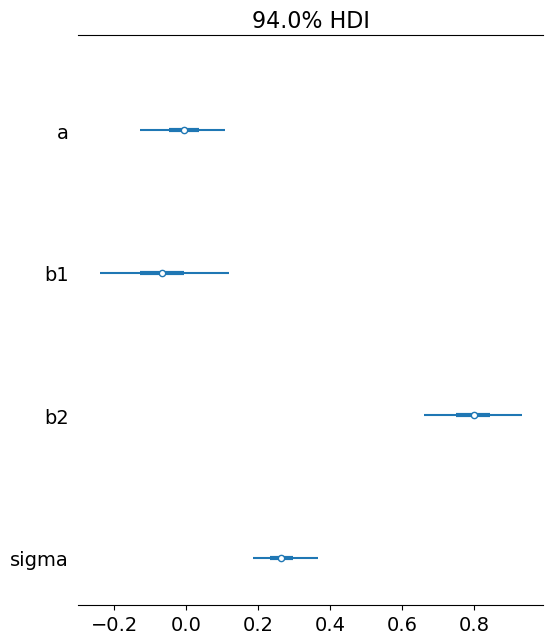

In [15]:
az.plot_forest(m_6m2,combined=True)

The difference between this and the leg -> height example is that in this example, x is related to y through z, but not directly related to y.  In the leg example, both leg heights are related to each other, and they are both directly "causal" of height.  So in this homework, the standard deviation of the parameter estimates are small and do not overlap.  With the leg example, the deviations are much wider and they overlap.

# 6M3 Question
 Learning to analyze DAGs requires practice. For each of the four DAGs below, state which variables, if any, you must adjust for (condition on) to estimate the total causal influence of X on Y.

Note: the DAGS are in the textbook question, but I am not replicating the image here.

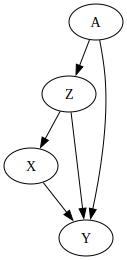

In [16]:
sixM3a = CausalGraphicalModel(
    nodes = ['Z','A','X','Y'],
    edges = [
    ('A','Z'),
    ('A','Y'),
    ('Z','X'),
    ('Z','Y'),
    ('X','Y')]
)
sixM3a.draw()

In [17]:
# X <- Z -> Y #Z is a fork
# X <- Z <- A ->Y #Z is a pipe, A is a collider.  
# If we condition on Z, that will close the backdoor through X and account for the information from A
sixM3a.get_all_backdoor_adjustment_sets('X','Y')

frozenset({frozenset({'Z'}), frozenset({'A', 'Z'})})

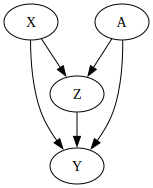

In [18]:
sixM3b = CausalGraphicalModel(
    nodes = ['Z','A','X','Y'],
    edges = [
    ('A','Z'),
    ('A','Y'),
    ('X','Z'),
    ('Z','Y'),
    ('X','Y')]
)
sixM3b.draw()

In [19]:
# X -> Z >- Y # This is a pipe.  So No change is needed here
# X -> Z <- A -> Y #In this, Z is a collider, so the path is already closed.
sixM3b.get_all_backdoor_adjustment_sets('X','Y')
#We can either condition on A or we don't need to condition at all since all backdoors are closed

frozenset({frozenset(), frozenset({'A'})})

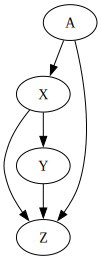

In [20]:
#6M3
sixM3c = CausalGraphicalModel(
    nodes = ['Z','A','X','Y'],
    edges = [
    ('A','Z'),
    ('A','X'),
    ('X','Z'),
    ('Y','Z'),
    ('X','Y')]
)
sixM3c.draw()

In [21]:
# X <- A -> Z <- Y #Z is a collider, and A is a fork.
# X -> Z <- Y #This path is closed
#So we don't need to make any adjustment, or we can condition on A
sixM3c.get_all_backdoor_adjustment_sets('X','Y')

frozenset({frozenset(), frozenset({'A'})})

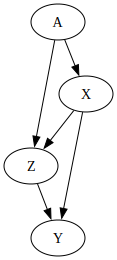

In [22]:
#6M3
sixM3d = CausalGraphicalModel(
    nodes = ['Z','A','X','Y'],
    edges = [
    ('A','Z'),
    ('A','X'),
    ('X','Z'),
    ('Z','Y'),
    ('X','Y')]
)
sixM3d.draw()

In [23]:
# X -> Z -> Y #Z is a pipe.  So we need to condition on Z to close the backdoor
# X <- A -> Z -> Y # Z is a pipe, while A is a fork

sixM3d.get_all_backdoor_adjustment_sets('X','Y')

frozenset({frozenset({'A'})})

# 6H1 Question 
Use the Waffle House data, data(WaffleDivorce), to find the total causal influence of number of Waffle Houses on divorce rate. Justify your model or models with a causal graph.

In [24]:
divorce = pd.read_csv('./data/WaffleDivorce.csv',sep=';')
divorce.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [25]:
lds_stats = pd.read_csv('./data/lds_stats.csv')
lds_stats['LDS_pct'] = np.round(lds_stats['Members'] / lds_stats['Population'],3)
lds_stats = lds_stats.rename(columns={'State':'Location'})
lds_stats.head()

,Location,Members,Population,LDS_pct
0,Alabama,39832.0,5074296.0,0.008
1,Alaska,33574.0,733583.0,0.046
2,Arizona,439411.0,7359197.0,0.060
3,Arkansas,35405.0,3045637.0,0.012
4,California,728995.0,39029342.0,0.019


In [26]:
divorce_lds = divorce.merge(lds_stats, on='Location')

In [27]:
training_data = divorce_lds[['Location','Loc','MedianAgeMarriage', 'Divorce','Marriage','LDS_pct','WaffleHouses','South']].copy()

In [28]:
training_data['MedAgeStd'] = (training_data['MedianAgeMarriage'] - training_data['MedianAgeMarriage'].mean())/training_data['MedianAgeMarriage'].std()
training_data['DivorceStd'] = (training_data['Divorce'] - training_data['Divorce'].mean())/training_data['Divorce'].std()
training_data['MarriageStd'] = (training_data['Marriage'] - training_data['Marriage'].mean())/training_data['Marriage'].std()
training_data['LDSStd'] = (training_data['LDS_pct'] - training_data['LDS_pct'].mean())/training_data['LDS_pct'].std()
training_data['WaffleHousesStd'] = (training_data['WaffleHouses'] - training_data['WaffleHouses'].mean())/training_data['WaffleHouses'].std()
training_data.head()

,Location,Loc,MedianAgeMarriage,Divorce,Marriage,LDS_pct,WaffleHouses,South,MedAgeStd,DivorceStd,MarriageStd,LDSStd,WaffleHousesStd
0,Alabama,AL,25.3,12.7,20.2,0.008,128,1,-0.606290,1.654205,0.022644,-0.262656,1.454029
1,Alaska,AK,25.2,12.5,26.0,0.046,0,0,-0.686699,1.544364,1.549802,0.134042,-0.491567
2,Arizona,AZ,25.8,10.8,20.3,0.060,18,0,-0.204241,0.610716,0.048974,0.280194,-0.217968
3,Arkansas,AR,24.3,13.5,26.4,0.012,41,1,-1.410387,2.093569,1.655123,-0.220898,0.131632
4,California,CA,26.8,8.0,19.1,0.019,0,0,0.599857,-0.927058,-0.266989,-0.147822,-0.491567


In [29]:
divorce.columns

Index(['Location', 'Loc', 'Population', 'MedianAgeMarriage', 'Marriage',
       'Marriage SE', 'Divorce', 'Divorce SE', 'WaffleHouses', 'South',
       'Slaves1860', 'Population1860', 'PropSlaves1860'],
      dtype='object')

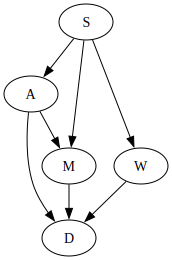

In [30]:
#S(outh),W(affleHouses),M(arraige),D(ivorce),A(geMarraige)
sixH1 = CausalGraphicalModel(
    nodes = ['S','W','M','A','D'],
    edges = [('S','W'),
             ('S','A'),
             ('S','M'),
             ('W','D'),
             ('M','D'),
             ('A','M'),
             ('A','D')])
sixH1.draw()

In [31]:
sixH1.get_all_backdoor_adjustment_sets('W','D')
#We can close all backdoor with S

frozenset({frozenset({'A', 'M'}),
           frozenset({'S'}),
           frozenset({'A', 'S'}),
           frozenset({'M', 'S'}),
           frozenset({'A', 'M', 'S'})})

In [32]:
with pm.Model() as m_6h1_a:
    a = pm.Normal('a', 0, 1)
    b_w = pm.Normal('b_w', 0,0.5)
    b_region = pm.Normal('b_region', 10,2,shape = 2)
    sigma = pm.Exponential('sigma',1)
    mu = a + b_w * training_data['WaffleHousesStd'] + b_region[training_data['South']]
    divorce = pm.Normal('divorce', mu, sigma, observed=training_data['Divorce'])
    m_6h1_a_trace = pm.sample()                    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_w, b_region, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


In [33]:
#Let's also try it without the conditioning
with pm.Model() as m_6h1_b:
    a = pm.Normal('a', 0, 1)
    b_w = pm.Normal('b_w', 0,0.5)
    sigma = pm.Exponential('sigma',1)
    mu = a + b_w * training_data['WaffleHousesStd']
    divorce = pm.Normal('divorce', mu, sigma, observed=training_data['Divorce'])
    m_6h1_b_trace = pm.sample()                    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [34]:
az.summary(m_6h1_a_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.012,0.813,-1.408,1.656,0.018,0.015,1955.0,1799.0,1.0
b_w,0.058,0.272,-0.464,0.553,0.006,0.005,2396.0,2211.0,1.0
b_region[0],9.352,0.860,7.582,10.849,0.019,0.014,2007.0,1832.0,1.0
b_region[1],10.600,0.916,8.906,12.337,0.020,0.014,2117.0,2359.0,1.0
sigma,1.750,0.182,1.403,2.071,0.004,0.003,2365.0,2127.0,1.0


In [35]:
az.summary(m_6h1_b_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,9.027,0.299,8.457,9.568,0.006,0.004,2679.0,2561.0,1.0
b_w,0.358,0.236,-0.059,0.849,0.003,0.003,4823.0,2837.0,1.0
sigma,1.910,0.224,1.520,2.332,0.004,0.003,2760.0,2836.0,1.0


If we don't include the Southern region variable, it looks like number of Waffle houses has some predictive power to divorce.  However, when we condition on S, WaffleHouses basically has no influence on Divorce Rate as the weight is basically 0.

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

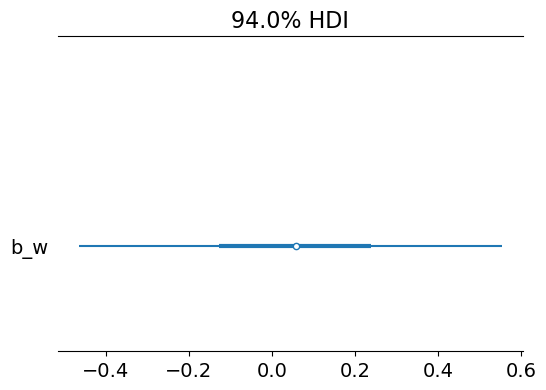

In [36]:
#Cofficient for Waffle House is centered around zero
az.plot_forest(m_6h1_a_trace, combined=True, var_names='b_w')

# 6H2 Question
 Build a series of models to test the implied conditional independencies of the causal graphyou used in the previous problem. If any of the tests fail, how do you think the graph needs to be amended? Does the graph need more or fewer arrows? Feel free to nominate variables that aren’t in the data.

In [37]:
sixH1.get_all_independence_relationships()

[('S', 'D', {'A', 'M', 'W'}),
 ('A', 'W', {'S'}),
 ('A', 'W', {'M', 'S'}),
 ('W', 'M', {'S'}),
 ('W', 'M', {'A', 'S'})]

In [38]:
with pm.Model() as m_6h2_a:
    a = pm.Normal('a', 0, 1)
    b_w = pm.Normal('b_w', 0,0.5)
    b_region = pm.Normal('b_region', 10,2,shape = 2)
    sigma = pm.Exponential('sigma',1)
    mu = a + b_w * training_data['WaffleHouses'] + b_region[training_data['South']]
    age = pm.Normal('w_house', mu, sigma, observed=training_data['MedianAgeMarriage'])
    m_6h2_a_trace = pm.sample()                    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_w, b_region, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


In [39]:
az.summary(m_6h2_a_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,5.120,0.845,3.569,6.700,0.022,0.016,1411.0,1855.0,1.0
b_w,0.005,0.004,-0.002,0.013,0.000,0.000,2659.0,2185.0,1.0
b_region[0],20.974,0.865,19.333,22.538,0.023,0.016,1414.0,1743.0,1.0
b_region[1],19.602,0.953,17.830,21.428,0.026,0.018,1360.0,1822.0,1.0
sigma,1.264,0.138,1.020,1.525,0.003,0.002,2385.0,2130.0,1.0


We can see that MedianAgeMarrage is independent of WaffleHouses (b_w) when conditioned on Regions since the b_w coefficient is 0

In [40]:
with pm.Model() as m_6h2_b:
    a = pm.Normal('a', 0, 1)
    b_w = pm.Normal('b_w', 0,0.5)
    b_region = pm.Normal('b_region', 10,2,shape = 2)
    sigma = pm.Exponential('sigma',1)
    mu = a + b_w * training_data['WaffleHouses'] + b_region[training_data['South']]
    m_rate = pm.Normal('m_rate', mu, sigma, observed=training_data['MarriageStd'])
    m_6h2_b_trace = pm.sample()                    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_w, b_region, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


In [41]:
az.summary(m_6h2_b_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-3.261,0.797,-4.721,-1.742,0.022,0.015,1360.0,1588.0,1.0
b_w,-0.003,0.003,-0.009,0.003,0.000,0.000,2371.0,2011.0,1.0
b_region[0],3.276,0.804,1.624,4.663,0.022,0.015,1363.0,1425.0,1.0
b_region[1],3.773,0.864,2.118,5.354,0.023,0.016,1438.0,1605.0,1.0
sigma,1.037,0.108,0.853,1.249,0.002,0.002,2170.0,1842.0,1.0


We can see that Marriage Rate is independent of WaffleHouses (b_w) when conditioned on Regions since the b_w coefficient is 0

In [42]:
with pm.Model() as m_6h2_c:
    #a = pm.Normal('a', 0, 2)
    b_w = pm.Normal('b_w', 0,0.5)
    b_a = pm.Normal('b_a', 0,0.5)
    b_m = pm.Normal('b_m', 0,0.5)
    b_region = pm.Normal('b_region', 0,0.5,shape = 2)
    sigma = pm.Exponential('sigma',1)
    mu = b_region[training_data['South']] + b_a * training_data['MedianAgeMarriage'] + b_m * training_data['MarriageStd'] + b_w * training_data['WaffleHousesStd']
    d_rate = pm.Normal('m_rate', mu, sigma, observed=training_data['DivorceStd'])
    m_6h2_c_trace = pm.sample()                    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_w, b_a, b_m, b_region, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


In [43]:
az.summary(m_6h2_c_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_w,0.092,0.157,-0.205,0.379,0.003,0.002,2967.0,2331.0,1.0
b_a,-0.000,0.014,-0.028,0.026,0.000,0.000,2179.0,2087.0,1.0
b_m,0.330,0.127,0.092,0.576,0.002,0.002,3515.0,2568.0,1.0
b_region[0],-0.132,0.378,-0.867,0.534,0.008,0.006,2157.0,2524.0,1.0
b_region[1],0.338,0.376,-0.389,1.029,0.007,0.005,2603.0,2715.0,1.0
sigma,0.911,0.098,0.734,1.088,0.002,0.001,3282.0,2897.0,1.0


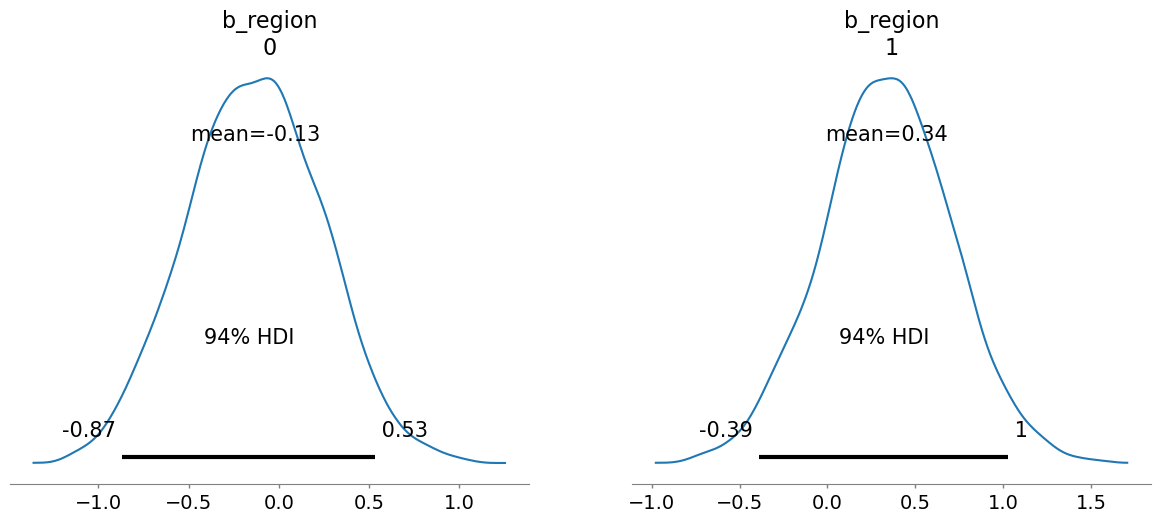

In [44]:
az.plot_posterior(m_6h2_c_trace, var_names=["b_region"]);

There is a slightly positive rate between Divorce Rate and Southern Status (b_region[1]).  Other variables that might be influencing things might be religion, and family size or population of young people

# 6H3 Question:
 Use a model to infer the total causal influence of area on weight. Would increasing the area available to each fox make it heavier (healthier)? You might want to standardize the variables. Regardless, use prior predictive simulation to show that your model’s prior predictions stay within the possible outcome range

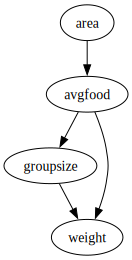

In [45]:

foxes = CausalGraphicalModel(
    nodes=["area", "avgfood", "groupsize", "weight"],
    edges=[
        ("area", "avgfood"),
        ("avgfood", "groupsize"),
        ("avgfood", "weight"),
        ("groupsize", "weight")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
foxes.draw()

In [46]:
fox_data = pd.read_csv('./data/foxes.csv')
fox_data.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


In [47]:
fox_data_std = fox_data.copy()
fox_data_std.iloc[:,1:5] = fox_data_std.iloc[:,1:5].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
fox_data_std.head()

,group,avgfood,groupsize,area,weight
0,1,-1.924829,-1.524089,-2.239596,0.414135
1,1,-1.924829,-1.524089,-2.239596,-1.427046
2,2,-1.118035,-1.524089,-1.205508,0.675954
3,2,-1.118035,-1.524089,-1.205508,1.300942
4,3,-1.319734,-1.524089,-1.130106,1.115135


In [48]:
n=50
areas_seq = np.linspace(-3,3,n)
intercepts = np.random.normal(0,0.2,n)
b_area_coefs = np.random.normal(0,0.5,n)

In [49]:
predictions = np.zeros((len(areas_seq), len(intercepts)))
for i, value in enumerate(areas_seq):
    predictions[i] = intercepts + (b_area_coefs * (value))

(-4.0, 4.0)

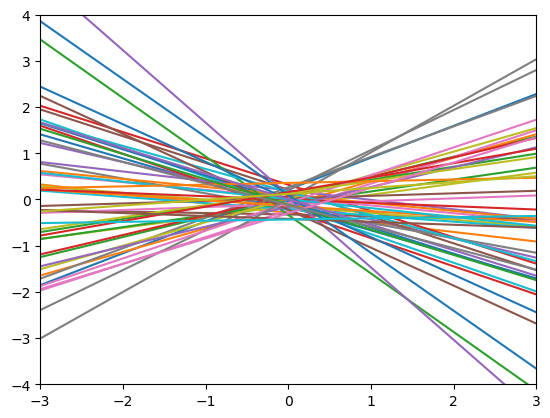

In [50]:
for i in predictions.T:
    plt.plot(areas_seq, i)
plt.xlim(-3,3);
plt.ylim(-4,4)

In [51]:
with pm.Model() as m_6h3:
    a = pm.Normal('a', 0, 0.2)
    b_area = pm.Normal('b_area', 0,0.5)
    sigma = pm.Exponential('sigma',1)
    mu = a + b_area * fox_data_std['area']
    weight = pm.Normal('weight', mu, sigma, observed=fox_data_std['weight'])
    m_6h3_trace = pm.sample()                    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_area, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


In [52]:
az.summary(m_6h3_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.087,-0.163,0.159,0.001,0.001,7055.0,2914.0,1.0
b_area,0.020,0.092,-0.161,0.189,0.001,0.001,5664.0,3184.0,1.0
sigma,1.010,0.066,0.885,1.132,0.001,0.001,5858.0,2930.0,1.0


The mean of area is close to zero, so it looks like area has no causal relationship to weight

In [53]:
foxes.get_all_backdoor_adjustment_sets('avgfood','weight')

frozenset({frozenset(), frozenset({'area'})})

# 6H4 Question: 
Now infer the causal impact of adding food to a territory. Would this make foxes heavier? Which covariates do you need to adjust for to estimate the total causal influence of food?

In [54]:
#6h4
with pm.Model() as m_6h4:
    a = pm.Normal('a', 0, 0.2)
    b_food = pm.Normal('b_food', 0,0.5)
    sigma = pm.Exponential('sigma',1)
    mu = a + b_food * fox_data_std['avgfood']
    weight = pm.Normal('weight', mu, sigma, observed=fox_data_std['weight'])
    m_6h4_trace = pm.sample()                    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_food, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [55]:
az.summary(m_6h4_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.000,0.082,-0.154,0.151,0.001,0.001,7172.0,3476.0,1.0
b_food,-0.025,0.090,-0.196,0.136,0.001,0.001,5919.0,3380.0,1.0
sigma,1.010,0.070,0.882,1.144,0.001,0.001,5398.0,2920.0,1.0


The mean of avg_food is close to zero, so it looks like it has no causal relationship to weight

# 6H5 Question
 Now infer the causal impact of group size. Which covariates do you need to adjust for? Looking at the posterior distribution of the resulting model, what do you think explains these data? That is, can you explain the estimates for all three problems? How do they go together?

In [56]:
foxes.get_all_backdoor_adjustment_sets('groupsize','weight')

frozenset({frozenset({'avgfood'}), frozenset({'area', 'avgfood'})})

In [57]:
with pm.Model() as m_6h5:
    a = pm.Normal('a', 0, 0.2)
    b_food = pm.Normal('b_food', 0,0.5)
    b_groupsize = pm.Normal('b_groupsize', 0,0.5)
    sigma = pm.Exponential('sigma',1)
    mu = a + b_groupsize * fox_data_std['groupsize'] + b_food * fox_data_std['avgfood']
    weight = pm.Normal('weight', mu, sigma, observed=fox_data_std['weight'])
    m_6h5_trace = pm.sample()                    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_food, b_groupsize, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [58]:
az.summary(m_6h5_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.000,0.081,-0.149,0.153,0.001,0.001,3799.0,2630.0,1.0
b_food,0.469,0.183,0.121,0.806,0.004,0.003,2273.0,2624.0,1.0
b_groupsize,-0.562,0.181,-0.903,-0.224,0.004,0.003,2182.0,2337.0,1.0
sigma,0.965,0.064,0.851,1.088,0.001,0.001,3609.0,2872.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

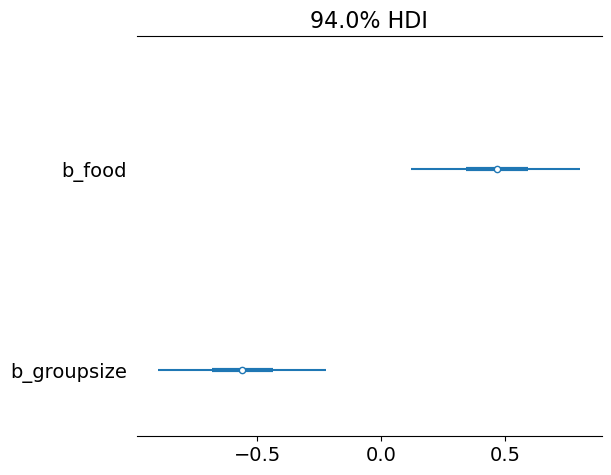

In [59]:
az.plot_forest(m_6h5_trace, combined=True, var_names=['b_food','b_groupsize'])

The groupsize is basically masking the effect of avgfood.  In this case, probably hunting in packs has a causal effect on how much food they can catch, but if the pack is too big they each get less food which means the avg weight is less.  Note that what might be going on here is the the average amount of food has no causal affect on weight, because the group size tends to offset the effect of the food size.  Larger groups will have more food, but individually they each get less food.

# 6H6 Question 
Consider your own research question. Draw a DAG to represent it. What are the testable implications of your DAG? Are there any variables you could condition on to close all backdoor paths? Are there unobserved variables that you have omitted? Would a reasonable colleague imagine additional threats to causal inference that you have ignored?

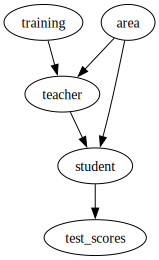

In [60]:
teacher = CausalGraphicalModel(
    nodes=["teacher", "student", "area", "training","test_scores"],
    edges=[
        ("training", "teacher"),
        ("teacher", "student"),
        ("student", "test_scores"),
        ("area","student"),
        ("area", "teacher")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
teacher.draw()

In [61]:
teacher.get_all_backdoor_adjustment_sets('teacher','test_scores')

frozenset({frozenset({'area'}), frozenset({'area', 'training'})})